In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File path for carbon intensity dataset
PATH = "../data/processed/df_carbon.parquet"

# Keeps the DATETIME column as an index
df_carbon = pd.read_parquet(PATH)

# Sort Ascending order by index (DATETIME)
df_carbon = df_carbon.sort_index()

In [3]:
# File path for predictions dataset
PATH = "../data/predictions/ci_predictions.parquet"

df_preds = pd.read_parquet(PATH)

# Sort Ascending order by index (DATETIME)
df_preds = df_preds.sort_index()

In [4]:
print(df_preds.index.min(), df_preds.index.max())
print(df_preds[["CI_actual", "CI_pred"]].head())
print(df_preds[["CI_actual", "CI_pred"]].tail())

2020-01-08 00:00:00+00:00 2025-11-21 09:00:00+00:00
                           CI_actual    CI_pred
DATETIME                                       
2020-01-08 00:00:00+00:00       87.0  84.554214
2020-01-08 01:00:00+00:00       82.0  85.089449
2020-01-08 02:00:00+00:00       82.0  80.816576
2020-01-08 03:00:00+00:00       79.5  81.066568
2020-01-08 04:00:00+00:00       80.0  80.726344
                           CI_actual     CI_pred
DATETIME                                        
2025-11-21 05:00:00+00:00      244.0  236.582649
2025-11-21 06:00:00+00:00      255.0  249.999775
2025-11-21 07:00:00+00:00      257.5  258.032925
2025-11-21 08:00:00+00:00      254.5  256.753515
2025-11-21 09:00:00+00:00      241.0  245.067245


In [5]:
ci_actual_day = df_preds.loc["2024-02-05", "CI_actual"]
print(len(ci_actual_day), ci_actual_day.index[0], ci_actual_day.index[-1])

24 2024-02-05 00:00:00+00:00 2024-02-05 23:00:00+00:00


# Base high-usage UK household profile (14kwh/day)

In [6]:
# Base high-usage UK household profile (14 kWh/day)
HOUSEHOLD_PROFILE_RAW = np.array([
    0.25, 0.23, 0.22, 0.22, 0.25,  # 00–04
    0.35, 0.55, 0.65, 0.60,        # 05–08
    0.55, 0.50, 0.48, 0.47, 0.50, 0.55,  # 09–14
    0.60, 0.75, 1.10, 1.20, 1.05,  # 15–19 (evening peak)
    0.70, 0.55, 0.40, 0.30         # 20–23
])

def make_household_profile(daily_kwh: float = 14.0) -> np.ndarray:
    """
    Return a 24-element array of hourly kWh for a single day,
    scaled so the total equals daily_kwh.
    """
    raw = HOUSEHOLD_PROFILE_RAW.copy()
    scale = daily_kwh / raw.sum()
    return raw * scale

A generic function that can:

- Take a carbon intensity series (24 hourly values)
- Optionally a renewable share series (for the “renewables” strategy)
- A flexible share (0–0.5)
- A strategy: "low_intensity" or "max_renewable"

Returns:
- baseline load + emissions
- shifted load + emissions
- summary stats

In [7]:
def compute_renewable_share(df_day: pd.DataFrame) -> pd.Series:
    """
    Compute renewable share (0–1) from RENEWABLE and GENERATION for a given day slice.
    """
    share = df_day["RENEWABLE"] / df_day["GENERATION"]
    return share.clip(lower=0.0, upper=1.0)

In [8]:
def run_shift_scenario(
    ci_series: pd.Series,
    daily_kwh: float = 14.0,
    flexible_share: float = 0.3,
    strategy: str = "low_intensity",
    renewable_share: pd.Series | None = None,
    n_target_hours: int = 4,
) -> dict:
    # Ensure sorted and 24 hours
    ci_series = ci_series.sort_index()
    assert len(ci_series) == 24, "ci_series must contain exactly 24 hourly values"

    if strategy == "max_renewable":
        if renewable_share is None:
            raise ValueError("renewable_share is required for 'max_renewable' strategy")
        renewable_share = renewable_share.loc[ci_series.index].sort_index()

    # Build baseline load profile
    baseline_load = make_household_profile(daily_kwh)  # kWh per hour
    index = ci_series.index

    # Split into non-flexible and flexible components
    baseline_load = pd.Series(baseline_load, index=index)
    nonflex_load = baseline_load * (1.0 - flexible_share)
    flex_load = baseline_load * flexible_share

    total_flex_energy = flex_load.sum()

    # Decide destination hours (where to move flex usage)
    if strategy == "low_intensity":
        # Sort hours by ascending carbon intensity
        target_order = ci_series.sort_values(ascending=True).index
    elif strategy == "max_renewable":
        # Sort hours by descending renewable share
        target_order = renewable_share.sort_values(ascending=False).index
    else:
        raise ValueError("strategy must be 'low_intensity' or 'max_renewable'")

    # Allocate flexible energy into target hours
    shifted_flex = pd.Series(0.0, index=index)
    remaining_energy = total_flex_energy

    for ts in target_order:
        if remaining_energy <= 0:
            break
        # For now: we allow arbitrary capacity per hour, just spread evenly
        # You can impose caps later if you want.
        # Simple strategy: fill up to original flex_load[ts] + some factor, or just distribute evenly.
        # Here: just proportionally spread over sorted hours.
        # We'll divide remaining energy equally over all remaining target slots.
        hours_left = (target_order == ts).sum()  # wrong: so simplify instead
        # To keep it simple: assign a fixed chunk
        chunk = total_flex_energy / len(target_order)
        assign = min(chunk, remaining_energy)
        shifted_flex[ts] += assign
        remaining_energy -= assign

    # If numerical leftovers remain, dump them into the best hour
    if remaining_energy > 1e-6:
        best_ts = target_order[0]
        shifted_flex[best_ts] += remaining_energy
        remaining_energy = 0.0

    # Build final shifted load
    shifted_load = nonflex_load + shifted_flex

    # Emissions (gCO2) = kWh * gCO2/kWh
    ci_array = ci_series.values
    baseline_emissions = baseline_load.values * ci_array
    shifted_emissions = shifted_load.values * ci_array

    total_baseline_emissions = baseline_emissions.sum()
    total_shifted_emissions = shifted_emissions.sum()

    relative_reduction = (
        (total_baseline_emissions - total_shifted_emissions) / total_baseline_emissions
    )

    return {
        "index": index,
        "ci": ci_array,
        "baseline_load": baseline_load.values,
        "shifted_load": shifted_load.values,
        "baseline_emissions": baseline_emissions,
        "shifted_emissions": shifted_emissions,
        "total_baseline_emissions": total_baseline_emissions,
        "total_shifted_emissions": total_shifted_emissions,
        "relative_reduction": relative_reduction,
    }

Note: the allocation loop is intentionally simple. It can be redefined later (e.g., allocate equal proportion into lowest-intensity hours only, or cap hourly shifted load).

# Historical mode

In [9]:
def get_day_slice(df: pd.DataFrame, date: str) -> pd.DataFrame:
    """
    Return a single calendar day's worth of data (24h) from a datetime-indexed df.
    date: 'YYYY-MM-DD'
    """
    day_df = df.loc[date:date]
    if len(day_df) != 24:
        raise ValueError(f"Expected 24 rows for {date}, got {len(day_df)}")
    return day_df

# Forecast mode - On a Specific Date

In [22]:
date = "2024-01-01"

# Full grid data for the day (for RENEWABLE and GENERATION)
df_day = get_day_slice(df_carbon, date)

# Carbon intensity from actuals
ci_actual_day = df_preds.loc[date, "CI_actual"]

# Renewable share from RENEWABLE / GENERATION
renewable_share_day = compute_renewable_share(df_day)

scenario_low_hist = run_shift_scenario(
    ci_series=ci_actual_day,
    daily_kwh=14.0,
    flexible_share=0.3,
    strategy="low_intensity",
    renewable_share=renewable_share_day,
)

scenario_renew_hist = run_shift_scenario(
    ci_series=ci_actual_day,
    daily_kwh=14.0,
    flexible_share=0.3,
    strategy="max_renewable",
    renewable_share=renewable_share_day,
)

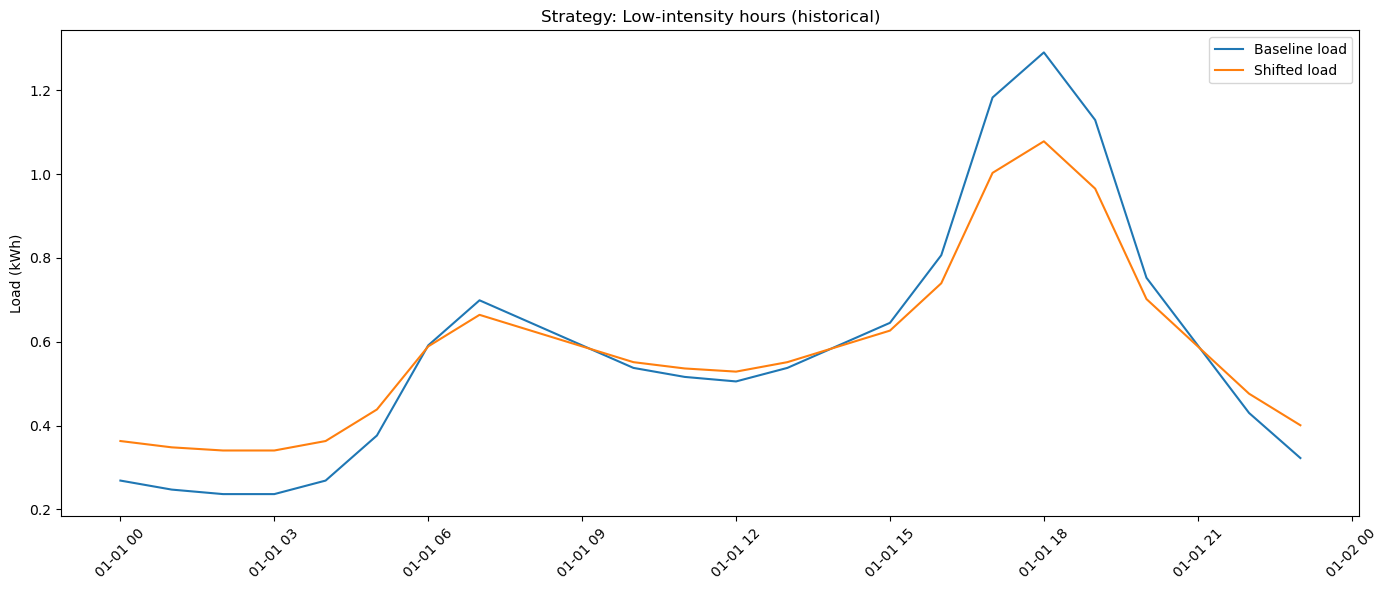

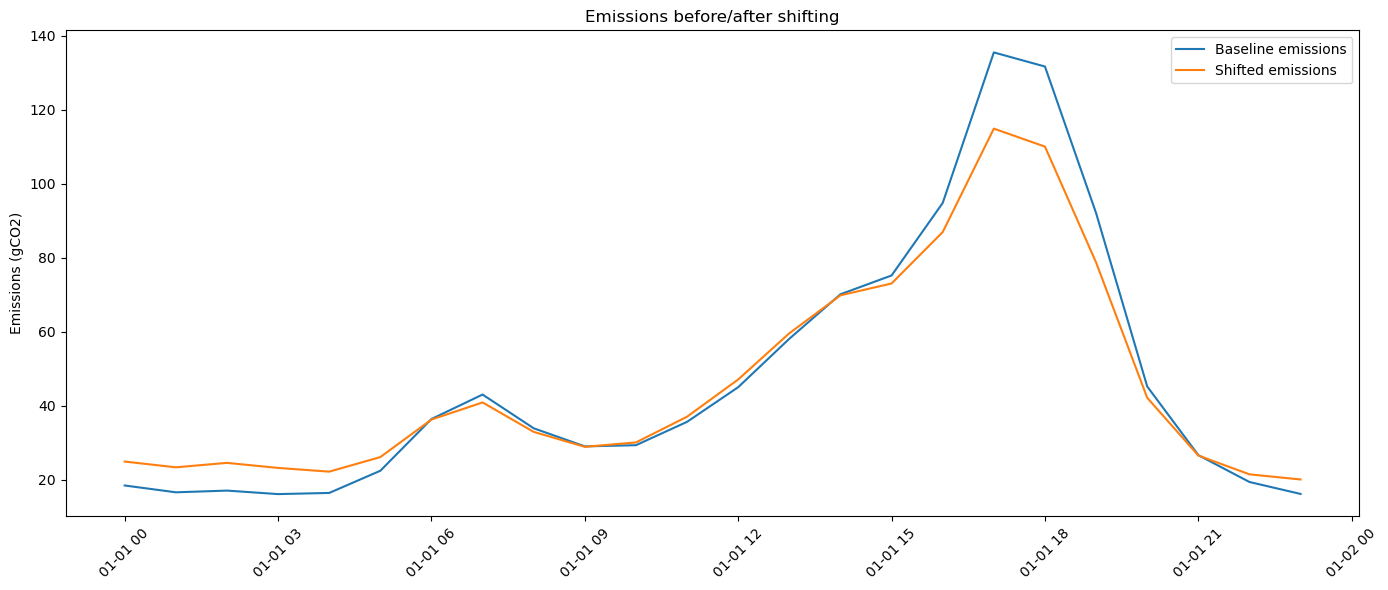

Total baseline emissions: 1123 gCO2
Total shifted emissions:  1100 gCO2
Relative reduction:       2.09%


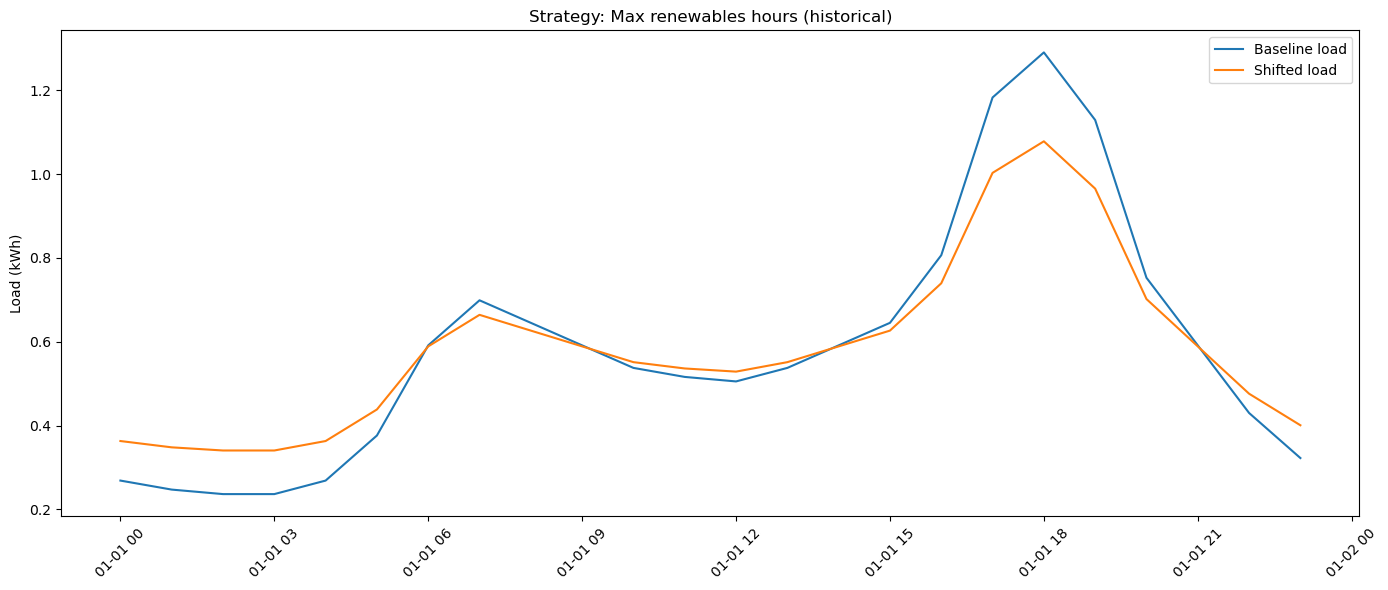

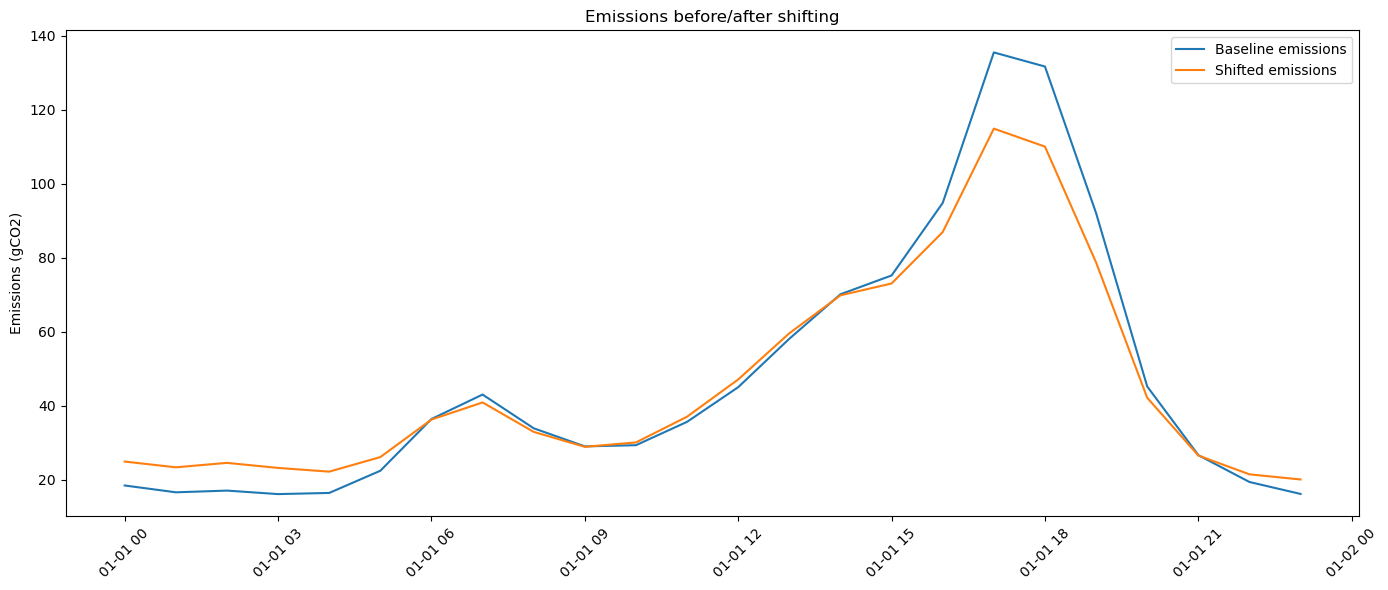

Total baseline emissions: 1123 gCO2
Total shifted emissions:  1100 gCO2
Relative reduction:       2.09%


In [23]:
def plot_scenario(result: dict, title: str = ""):
    idx = result["index"]

    plt.figure(figsize=(14, 6))
    plt.plot(idx, result["baseline_load"], label="Baseline load")
    plt.plot(idx, result["shifted_load"], label="Shifted load")
    plt.ylabel("Load (kWh)")
    plt.title(title or "Household load before/after shifting")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.plot(idx, result["baseline_emissions"], label="Baseline emissions")
    plt.plot(idx, result["shifted_emissions"], label="Shifted emissions")
    plt.ylabel("Emissions (gCO2)")
    plt.title("Emissions before/after shifting")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Total baseline emissions: {result['total_baseline_emissions']:.0f} gCO2")
    print(f"Total shifted emissions:  {result['total_shifted_emissions']:.0f} gCO2")
    print(f"Relative reduction:       {result['relative_reduction']*100:.2f}%")

# Example usage:
plot_scenario(scenario_low_hist,   title="Strategy: Low-intensity hours (historical)")
plot_scenario(scenario_renew_hist, title="Strategy: Max renewables hours (historical)")

# Reduction Over Many Days

In [28]:
def daily_reduction_for_range(
    start_date: str,
    end_date: str,
    strategy: str,
    flexible_share: float = 0.3,
    daily_kwh: float = 14.0,
):
    reductions = []
    dates = pd.date_range(start_date, end_date, freq="D")

    for d in dates:
        date_str = d.strftime("%Y-%m-%d")
        try:
            df_day = get_day_slice(df_carbon, date_str)
            ci_day = df_preds.loc[date_str, "CI_actual"]
            renew_share = compute_renewable_share(df_day)

            scenario = run_shift_scenario(
                ci_series=ci_day,
                daily_kwh=daily_kwh,
                flexible_share=flexible_share,
                strategy=strategy,
                renewable_share=renew_share,
            )
            reductions.append(scenario["relative_reduction"])
        except Exception:
            # skip incomplete days
            continue

    return dates[:len(reductions)], np.array(reductions)

In [29]:
dates_low, red_low = daily_reduction_for_range(
    "2024-01-01", "2024-12-31", strategy="low_intensity", flexible_share=0.3
)

dates_ren, red_ren = daily_reduction_for_range(
    "2024-01-01", "2024-12-31", strategy="max_renewable", flexible_share=0.3
)

print("Low-intensity: mean reduction %:", red_low.mean() * 100)
print("Max-renewable: mean reduction %:", red_ren.mean() * 100)
print("Best day (low-intensity):", red_low.max() * 100)
print("Best day (max-renewable):", red_ren.max() * 100)

Low-intensity: mean reduction %: 1.648555821708372
Max-renewable: mean reduction %: 1.648555821708372
Best day (low-intensity): 4.9312124342927275
Best day (max-renewable): 4.9312124342927275


# Daily Reductions over a Date Range

In [30]:
def compute_daily_reductions_over_range(
    start_date: str,
    end_date: str,
    flexible_share: float = 0.3,
    daily_kwh: float = 14.0,
) -> pd.DataFrame:
    """
    Compute daily relative emission reductions for low_intensity and max_renewable
    strategies between start_date and end_date (inclusive).

    Returns a DataFrame indexed by date with columns:
    - strategy
    - reduction (fraction, not %)
    """
    dates = pd.date_range(start_date, end_date, freq="D")
    rows = []

    for d in dates:
        date_str = d.strftime("%Y-%m-%d")
        try:
            # Full grid data for that day (for RENEWABLE and GENERATION)
            df_day = get_day_slice(df_carbon, date_str)
            # Use ACTUAL carbon intensity here
            ci_day = df_preds.loc[date_str, "CI_actual"]
            renew_share = compute_renewable_share(df_day)
        except Exception:
            # Skip incomplete or missing days
            continue

        for strategy in ("low_intensity", "max_renewable"):
            scenario = run_shift_scenario(
                ci_series=ci_day,
                daily_kwh=daily_kwh,
                flexible_share=flexible_share,
                strategy=strategy,
                renewable_share=renew_share,
            )
            rows.append(
                {
                    "date": d.normalize(),
                    "strategy": strategy,
                    "reduction": scenario["relative_reduction"],
                }
            )

    df_red = pd.DataFrame(rows)
    if df_red.empty:
        raise ValueError("No valid days found in the given range")

    df_red = df_red.set_index("date").sort_index()
    return df_red

In [31]:
# Example for 2024
df_red_2024 = compute_daily_reductions_over_range(
    "2024-01-01", "2024-12-31",
    flexible_share=0.3,
    daily_kwh=14.0,
)

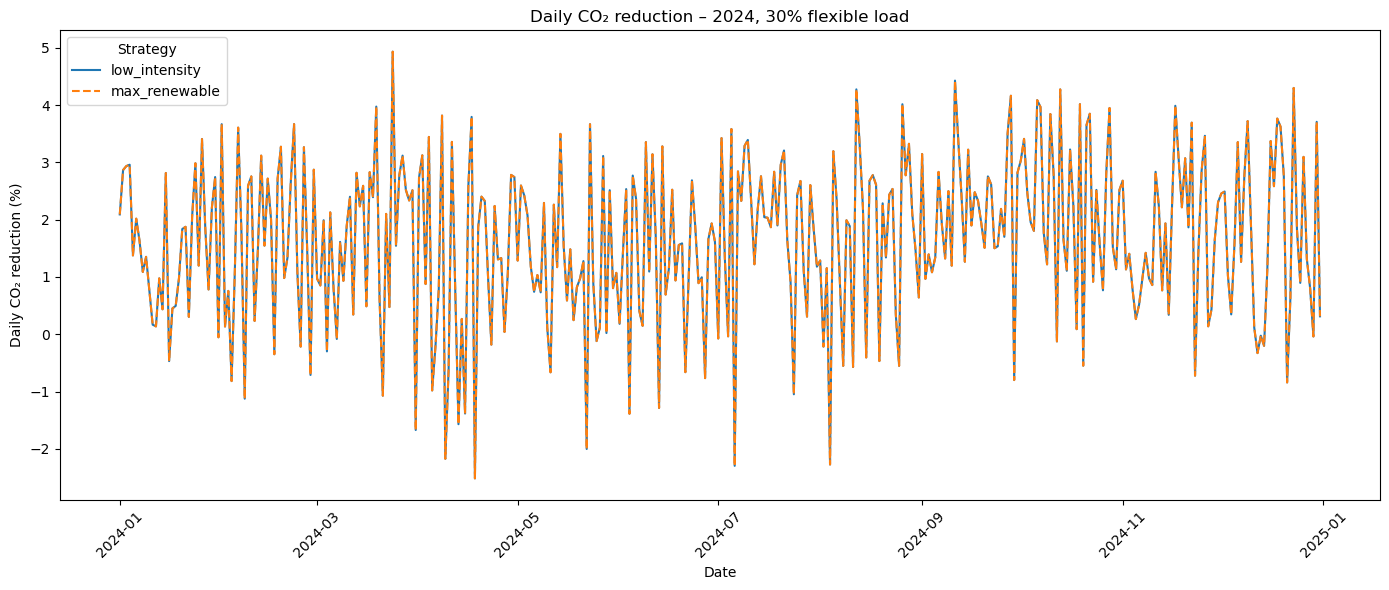

In [53]:
def plot_yearly_reduction(df_red: pd.DataFrame, title: str = ""):
    # Pivot to have one column per strategy
    df_pivot = df_red.pivot(columns="strategy", values="reduction")

    plt.figure(figsize=(14, 6))
    plt.plot(df_pivot.index, df_pivot["low_intensity"] * 100, label="low_intensity", linestyle="-")
    plt.plot(df_pivot.index, df_pivot["max_renewable"] * 100, label="max_renewable", linestyle="--")

    
    plt.ylabel("Daily CO₂ reduction (%)")
    plt.xlabel("Date")
    plt.title(title or "Daily emission reduction over the year")
    plt.legend(title="Strategy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example:
plot_yearly_reduction(df_red_2024, title="Daily CO₂ reduction – 2024, 30% flexible load")

In [42]:
df_pivot = df_red_2024.pivot(columns="strategy", values="reduction")

df_pivot["diff"] = df_pivot["low_intensity"] - df_pivot["max_renewable"]
print("Max abs diff:", df_pivot["diff"].abs().max())
print(df_pivot.head(12))

Max abs diff: 0.0
strategy    low_intensity  max_renewable  diff
date                                          
2024-01-01       0.020918       0.020918   0.0
2024-01-02       0.028659       0.028659   0.0
2024-01-03       0.029356       0.029356   0.0
2024-01-04       0.029588       0.029588   0.0
2024-01-05       0.013763       0.013763   0.0
2024-01-06       0.020175       0.020175   0.0
2024-01-07       0.016332       0.016332   0.0
2024-01-08       0.010882       0.010882   0.0
2024-01-09       0.013513       0.013513   0.0
2024-01-10       0.007622       0.007622   0.0
2024-01-11       0.001682       0.001682   0.0
2024-01-12       0.001382       0.001382   0.0


This shows how savings fluctuate through the year and whether there’s any seasonal shape.

# Histogram of Daily Reductions for each Strategy

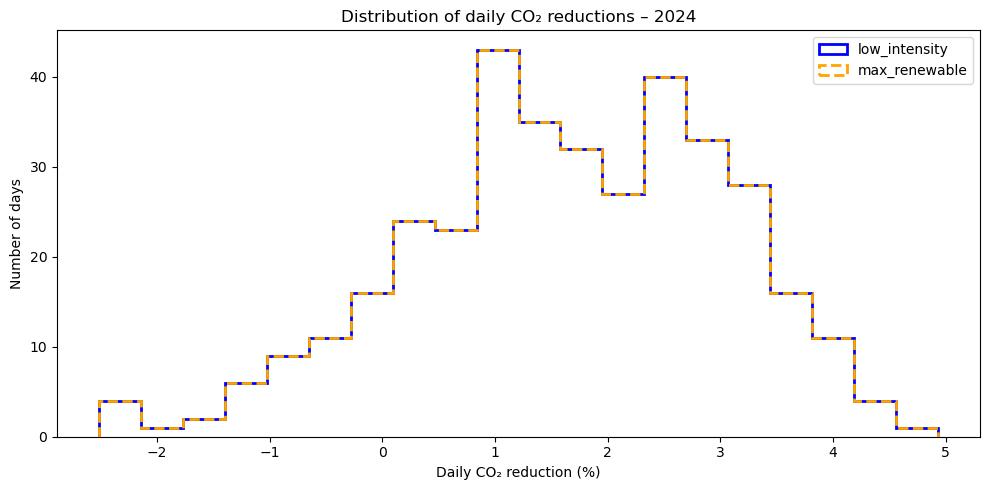

In [55]:
def plot_reduction_histogram(df_red: pd.DataFrame, bins: int = 20, title: str = ""):
    df_pivot = df_red.pivot(columns="strategy", values="reduction")

    low_vals = (df_pivot["low_intensity"].dropna() * 100).values
    ren_vals = (df_pivot["max_renewable"].dropna() * 100).values

    # Shared bin edges so shapes align perfectly
    min_val = min(low_vals.min(), ren_vals.min())
    max_val = max(low_vals.max(), ren_vals.max())
    bins_edges = np.linspace(min_val, max_val, bins + 1)

    plt.figure(figsize=(10, 5))

    # Step histogram (outline only)
    plt.hist(
        low_vals, bins=bins_edges, histtype="step",
        linewidth=2, linestyle="-", color="blue",
        label="low_intensity"
    )

    plt.hist(
        ren_vals, bins=bins_edges, histtype="step",
        linewidth=2, linestyle="--", color="orange",
        label="max_renewable"
    )

    plt.xlabel("Daily CO₂ reduction (%)")
    plt.ylabel("Number of days")
    plt.title(title or "Distribution of Daily CO₂ Reductions")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_reduction_histogram(df_red_2024, bins=20, title="Distribution of daily CO₂ reductions – 2024")

# Summary Table

In [60]:
def style_reduction_summary(summary_df: pd.DataFrame):
    """
    summary_df: from summarize_reductions(df_red)
    Columns: ['mean_%', 'std_%', 'min_%', 'max_%', 'n_days']
    """
    styled = (
        summary_df.style
        .format(
            {
                "mean_%": "{:.2f}",
                "std_%": "{:.2f}",
                "min_%": "{:.2f}",
                "max_%": "{:.2f}",
                "n_days": "{:.0f}",
            }
        )
        .background_gradient(
            subset=["mean_%", "max_%"],
            cmap="Greens",
        )
        .set_caption("Summary of daily CO₂ reduction by strategy (2024)")
    )
    return styled

# Example:
style_reduction_summary(summary_2024)

,mean_%,std_%,min_%,max_%,n_days
strategy,,,,,
low_intensity,1.65,1.39,-2.51,4.93,366
max_renewable,1.65,1.39,-2.51,4.93,366


# Results Section

## 5. Results – Household Load Shifting Impact

Using a high-usage UK household profile (≈14 kWh/day, 30% flexible load) and
system-wide carbon intensity for 2024, I evaluated two shifting strategies:

- **low_intensity** – shift flexible load into the lowest-carbon hours each day  
- **max_renewable** – shift flexible load into the hours with the highest renewable share (RENEWABLE / GENERATION)

### 5.1 Daily reduction over the year

The time series of daily CO₂ reduction shows:

- Typical daily savings are modest, mostly between **0% and ~3%**  
- Occasional days reach up to **≈5%** reduction

The two strategies produce visually indistinguishable curves: “lowest-carbon hours”
and “highest-renewables hours” align almost perfectly in the modern UK grid.

### 5.2 Distribution of daily reductions

The distribution of daily reduction percentages is tightly clustered:

- Most days sit around **1–2%** savings  
- The left tail includes days with **slightly negative impact** (up to **–2.5%**),
  where shifting actually *increases* emissions due to flat or atypical intensity profiles  
- The right tail peaks at ~**4.9%** for the best days

### 5.3 Summary statistics

Averaged over 366 days in 2024:

- **Mean daily reduction:** ~**1.65%** for both strategies  
- **Standard deviation:** ~**1.39%**  
- **Minimum:** **–2.51%**  
- **Maximum:** **4.93%**

Both strategies yield **identical** statistics because, in this period, the hours
with the highest renewable penetration are also the lowest-carbon hours. In other words,
“shift to renewables” and “shift to low carbon” collapse into the same policy in the
current UK grid mix.
